# Machine Learning Model Training - Universal Pipeline

This notebook provides a complete, universal machine learning pipeline that automatically adapts to your data.

## Objectives
- Load preprocessed datasets
- Automatically detect problem type (classification vs regression)
- Perform grid search on appropriate models
- Train best model on combined train+validation data
- Save the final model for production use

## Features
- ✅ **Universal**: Works with any target type (binary, multiclass, regression)
- ✅ **Automatic**: Detects problem type and applies appropriate models
- ✅ **Optimized**: Grid search with cross-validation
- ✅ **Production-ready**: Final model trained on maximum data
- ✅ **Persistent**: Save best model and configuration

In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import custom functions with reload for development
import sys
sys.path.append('../')
import importlib

# Import and reload modules to get latest changes
import functions.data_utils as data_utils
import functions.ml_utils as ml_utils
importlib.reload(data_utils)
importlib.reload(ml_utils)

from functions.data_utils import load_datasets, create_preprocessing_pipeline, load_splitted_datasets , cleanup_project_files, cleanup_project_files_silent, cleanup_processed_and_splitted, cleanup_processed_and_splitted_silent
from functions.ml_utils import (
    detect_problem_type, encode_target,
    get_models_config, get_scoring_metric, get_cv_strategy,
    grid_search, plot_model_comparison,
    train_final_model, evaluate_model,
    save_model_artifacts,
    create_test_set_analysis,
    show_feature_importance_detailed,
    print_final_summary
)

# Set up plotting
plt.style.use('dark_background')

## Configuration

Set up the configuration parameters for model training.

In [50]:
# Configuration parameters
DATASETS_PATH = '../data/processed'  # Path to processed datasets
SPLITTED_PATH = '../data/splitted'   # Path to raw split datasets
MODELS_PATH = '../models'  # Path to save models
TARGET_TYPE = 'auto'  # 'auto', 'classification', 'regression'
CV_FOLDS = 5  # Number of cross-validation folds
RANDOM_STATE = 42  # For reproducibility
N_JOBS = -1  # Use all available cores

print(f"Processed datasets path: {DATASETS_PATH}")
print(f"Splitted datasets path: {SPLITTED_PATH}")
print(f"Models path: {MODELS_PATH}")
print(f"Target type: {TARGET_TYPE}")
print(f"CV folds: {CV_FOLDS}")
print(f"Random state: {RANDOM_STATE}")

Processed datasets path: ../data/processed
Splitted datasets path: ../data/splitted
Models path: ../models
Target type: auto
CV folds: 5
Random state: 42


## Load Data

Load the preprocessed datasets and analyze the target variable.

In [51]:
# Load preprocessed datasets
X_train, X_val, X_test, y_train, y_val, y_test = load_datasets(DATASETS_PATH)

print("Dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

📊 Test set is empty - loading and processing raw test data...
🔧 Raw test data loaded: 200 samples
🔧 Target column name in raw data: 'diagnosis'
🔧 Loading RAW train+val data to create consistent transformers...
🔧 Creating NEW transformers from RAW train+val data to preserve column names...
Creating preprocessing pipeline for data shape: (800, 15)
Numeric columns: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present']
Categorical columns: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
Numeric columns (10): ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level']...
Categorical columns (5): ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
✅ Fitted numeric imputer on 10 columns
✅ Fitted categorical 

In [52]:
# Analyze target variable and detect problem type
problem_type = detect_problem_type(y_train, TARGET_TYPE)
print(f"Detected problem type: {problem_type}")

# Encode target if needed
y_train_proc, y_val_proc, y_test_proc, label_encoder = encode_target(
    y_train, y_val, y_test, problem_type
)

print(f"Processed target shapes: {y_train_proc.shape}, {y_val_proc.shape}, {y_test_proc.shape}")

Detected problem type: multiclass_classification
Encoding categorical target variable...
Target encoding mapping:
  Both -> 0
  Depression -> 1
  ME/CFS -> 2
Processed target shapes: (600,), (200,), (200,)


## Problem Type Detection and Target Encoding

Automatically detect the problem type and encode target if necessary.

## Model Selection and Grid Search Setup

Define models and hyperparameter grids based on the problem type.

In [53]:
# Create ML pipeline configuration
models_config = get_models_config(problem_type, RANDOM_STATE)
scoring_metric = get_scoring_metric(problem_type)
cv_strategy = get_cv_strategy(problem_type, y_train_proc, CV_FOLDS, RANDOM_STATE)

print(f"Models to evaluate: {list(models_config.keys())}")
print(f"Scoring metric: {scoring_metric}")
print(f"CV strategy: {type(cv_strategy).__name__}")

Models to evaluate: ['RandomForest', 'GradientBoosting', 'KNeighbors']
Scoring metric: f1_macro
CV strategy: StratifiedKFold


## Grid Search Execution

Perform grid search to find the best model and hyperparameters.

In [54]:
# Perform grid search to find best model and hyperparameters
grid_results, best_model_name, best_model = grid_search(
    X_train, y_train_proc, X_val, y_val_proc, 
    models_config, scoring_metric, cv_strategy, problem_type, N_JOBS
)

print(f"🏆 Best model: {best_model_name}")
print(f"🏆 Best validation score: {grid_results[best_model_name]['val_score']:.4f}")

Starting Grid Search...

🔍 Training RandomForest...
✅ RandomForest completed:
   Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training GradientBoosting...
✅ RandomForest completed:
   Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training GradientBoosting...
✅ GradientBoosting completed:
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training KNeighbors...
✅ GradientBoosting completed:
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training KNeighbors...
✅ KNeighbors completed:
   Best params: {'n_neighbors': 7, 'weights': 'uniform'}
   Train score (CV): 0.8170
   Validation score: 0.8467



## Model Evaluation and Visualization

Evaluate all models and visualize the results.

Model Comparison Results:
              Model  Train_Score  Validation_Score
0      RandomForest       0.9898            0.9877
1  GradientBoosting       0.9898            0.9877
2        KNeighbors       0.8170            0.8467


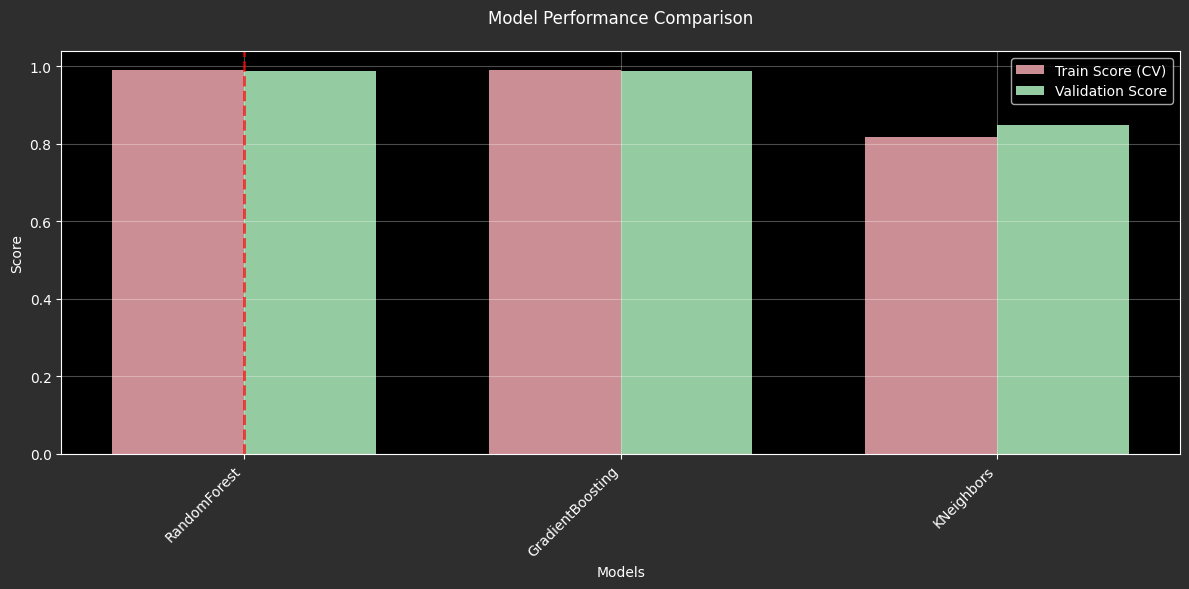

Model comparison completed and visualized.


In [55]:
# Evaluate and visualize model comparison results
plot_model_comparison(grid_results, best_model_name)
print("Model comparison completed and visualized.")

## Final Model Training

Retrain the best model on the combined train+validation dataset.

In [56]:
# Train final model on combined train+validation data
print("🔄 Training final model on combined train+validation data...")
print("📊 CRITICAL FIX: Loading RAW data splits to recalculate transformers correctly!")

# Load RAW datasets from splitted folder (prepared in notebook 01)
X_train_raw, X_val_raw, X_test_raw, y_train_raw, y_val_raw, y_test_raw = load_splitted_datasets(SPLITTED_PATH)

# Encode targets for the raw data
y_train_raw_proc, y_val_raw_proc, y_test_raw_proc, label_encoder_new = encode_target(
    y_train_raw, y_val_raw, y_test_raw, problem_type
)

# Combine RAW train and validation datasets BEFORE preprocessing
X_combined_raw = pd.concat([X_train_raw, X_val_raw], axis=0, ignore_index=True)
y_combined_raw = np.concatenate([y_train_raw_proc, y_val_raw_proc])

print(f"Combined RAW dataset shape: {X_combined_raw.shape}")

# Create NEW transformers fitted on combined RAW data
print("🔧 Creating and fitting transformers on combined RAW train+val data...")
transformers_combined = create_preprocessing_pipeline(X_combined_raw)
X_combined_transformed = transformers_combined['fit_transform'](X_combined_raw)

print(f"Transformed combined data shape: {X_combined_transformed.shape}")

# Train final model with properly calculated transformers
final_model = train_final_model(
    best_model_name, grid_results[best_model_name]['params'], 
    problem_type, X_combined_transformed, y_combined_raw, RANDOM_STATE
)

# Transform test set with the SAME transformers used for training (calculated on RAW data)
print("🔧 Applying final transformers to RAW test set...")
X_test_transformed = transformers_combined['transform'](X_test_raw)

# Evaluate on test set with properly transformed data
test_results = evaluate_model(final_model, X_test_transformed, y_test_raw_proc, problem_type, label_encoder_new)

print(f"✅ Final model trained and evaluated on test set with CORRECTED transformer pipeline.")
print(f"📈 Test set performance (with transformers calculated on RAW combined data):")
for metric, value in test_results.items():
    if value is not None:
        print(f"  {metric}: {value:.4f}")

🔄 Training final model on combined train+validation data...
📊 CRITICAL FIX: Loading RAW data splits to recalculate transformers correctly!
Split RAW datasets loaded successfully from ../data/splitted/
Loaded datasets:
  - X_train_raw: (600, 15)
  - X_val_raw: (200, 15)
  - X_test_raw: (200, 15)
  - y_train_raw: (600,)
  - y_val_raw: (200,)
  - y_test_raw: (200,)
Encoding categorical target variable...
Target encoding mapping:
  Both -> 0
  Depression -> 1
  ME/CFS -> 2
Combined RAW dataset shape: (800, 15)
🔧 Creating and fitting transformers on combined RAW train+val data...
Creating preprocessing pipeline for data shape: (800, 15)
Numeric columns: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present']
Categorical columns: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
Numeric c

## Save Final Model and Artifacts

Save the trained model and all necessary artifacts for production use.

🎯 Test Set Performance Analysis:


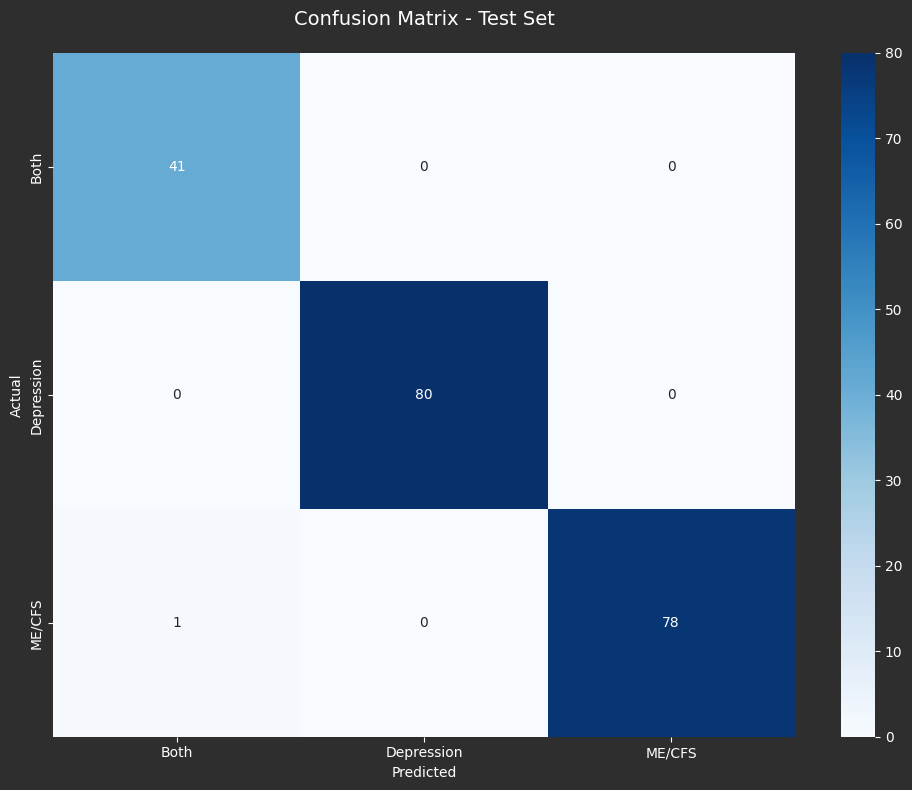


📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Both       0.98      1.00      0.99        41
  Depression       1.00      1.00      1.00        80
      ME/CFS       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200

🔍 Feature Importance Analysis:
📊 Top 15 Most Important Features:


,feature,importance
5,feature_5,0.3766
9,feature_9,0.3482
6,feature_6,0.1238
1,feature_1,0.0196
2,feature_2,0.0195
4,feature_4,0.0172
8,feature_8,0.0169
3,feature_3,0.0160
7,feature_7,0.0146
0,feature_0,0.0146


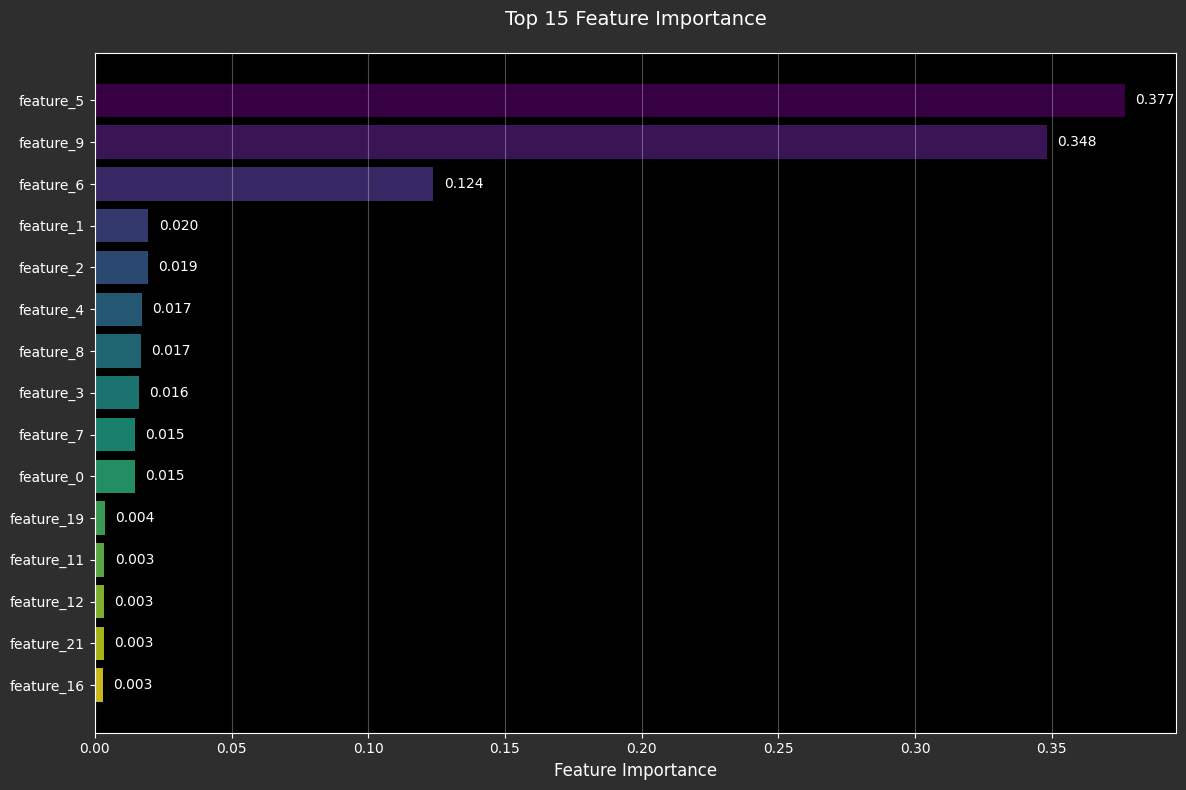

✅ Model and artifacts saved successfully!
📁 Final model: ../models/final_model.pkl
📁 Transformers: ../models/transformers.pkl
📁 Model metadata: ../models/model_metadata.pkl

📊 Model Summary:
   Model: RandomForest
   Problem type: multiclass_classification
   Features: 15
   Transformers: ✅ Included
🎉 FINAL ML PIPELINE SUMMARY
📊 Problem Type: multiclass_classification
🏆 Best Model: RandomForest
📈 Features: 15
📦 Dataset Split:
   - Training: 800 samples
   - Validation: 200 samples
   - Test: 200 samples
   - Total: 1200 samples

📈 Best Parameters:
   max_depth: 10
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100

📊 Final Test Performance:
   accuracy: 0.9950
   precision: 0.9921
   recall: 0.9958
   f1_score: 0.9939

💾 Saved Artifacts:
   📁 Model: ../models/final_model.pkl
   📁 Metadata: ../models/model_metadata.pkl

✅ Pipeline completed successfully!
🚀 Model ready for production deployment!


In [57]:
# Create detailed test set analysis (usando X_test_transformed e y_test RAW originale)
create_test_set_analysis(final_model, X_test_transformed, y_test_raw, problem_type, label_encoder_new)

# Show detailed feature importance analysis (usando le feature trasformate)
if hasattr(final_model, 'feature_importances_'):
    # Get the transformed feature names from the transformers
    if 'feature_names' in transformers_combined:
        transformed_feature_names = transformers_combined['feature_names']
    else:
        # Fallback: use indices if feature names not available
        n_features = len(final_model.feature_importances_)
        transformed_feature_names = [f'feature_{i}' for i in range(n_features)]
    
    show_feature_importance_detailed(final_model, transformed_feature_names)

# Save model and artifacts WITH CORRECTED TRANSFORMERS (no test set in models)
save_model_artifacts(
    final_model, best_model_name, problem_type, 
    grid_results[best_model_name]['params'], X_combined_raw, grid_results,
    test_results, label_encoder_new, transformers_combined, MODELS_PATH
)

# Print comprehensive final summary (usando X_combined_raw al posto di X_train)
print_final_summary(
    problem_type, best_model_name, grid_results[best_model_name]['params'],
    test_results, X_combined_raw, X_val_raw, X_test_raw, MODELS_PATH
)

In [58]:
X_test

,age,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,...,work_status_Working,social_activity_level_Low,social_activity_level_Medium,social_activity_level_Very high,social_activity_level_Very low,exercise_frequency_Never,exercise_frequency_Often,exercise_frequency_Rarely,exercise_frequency_Sometimes,meditation_or_mindfulness_Yes
0,-1.547674,0.024248,1.368897,0.655679,-0.620362,0.461964,0.685501,-1.118148,0.179036,-1.221561,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0.157481,-0.973600,0.902691,0.734867,1.620312,-0.353506,-2.242719,1.546753,-0.998188,-1.221561,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.075642,0.064162,0.902691,-1.324028,1.187901,0.625058,0.273720,0.658453,-0.213372,0.818625,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.367182,-1.452568,0.125681,-1.403216,1.030661,-0.516600,0.273720,-1.044123,-0.458627,0.818625,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.432765,-0.334978,0.086831,-1.601187,-0.659672,2.255999,0.639747,-0.673998,-0.900086,-1.221561,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.550978,1.660719,1.485448,-1.640781,1.620312,-0.516600,0.273720,1.398703,-0.801984,0.818625,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196,-0.367182,0.343559,-1.311787,0.972432,-0.148641,-0.190412,-1.281897,-0.229848,1.012903,-1.221561,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
197,1.075642,1.301493,-0.495926,0.022173,-0.305882,-0.353506,-0.412582,-1.636324,-0.654831,-1.221561,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
198,-0.760680,0.024248,-1.428338,-1.521999,0.558940,-0.353506,-2.288472,0.584428,-0.556729,-1.221561,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [59]:
# Test the updated load_datasets function
print("🧪 Testing load_datasets with automatic test set processing...")

# Test loading datasets
X_train_test, X_val_test, X_test_test, y_train_test, y_val_test, y_test_test = data_utils.load_datasets(DATASETS_PATH)

print("\n📊 Final dataset shapes after automatic processing:")
print(f"  - X_train: {X_train_test.shape}")
print(f"  - X_val: {X_val_test.shape}")
print(f"  - X_test: {X_test_test.shape}")
print(f"  - y_train: {y_train_test.shape}")
print(f"  - y_val: {y_val_test.shape}")
print(f"  - y_test: {y_test_test.shape}")

# Check if test set is now properly loaded
if len(X_test_test) > 0:
    print("✅ Test set successfully loaded and processed!")
else:
    print("⚠️ Test set is still empty")

🧪 Testing load_datasets with automatic test set processing...
📊 Test set is empty - loading and processing raw test data...
🔧 Raw test data loaded: 200 samples
🔧 Target column name in raw data: 'diagnosis'
🔧 Loading RAW train+val data to create consistent transformers...
🔧 Creating NEW transformers from RAW train+val data to preserve column names...
Creating preprocessing pipeline for data shape: (800, 15)
Numeric columns: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present']
Categorical columns: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
Numeric columns (10): ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level']...
Categorical columns (5): ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness'

## 🗑️ Project Cleanup Utility

This section provides utilities to clean up files from the project.

### When to use cleanup:
- **Before switching datasets**: Clear all processed and split data
- **After testing**: Remove temporary files from experiments  
- **Storage management**: Free up disk space
- **Fresh start**: Reset the project to use new original data

### Cleanup Options:

#### 1. **Partial Cleanup** (Old behavior)
- `cleanup_project_files()` / `cleanup_project_files_silent()`
- Removes only `*.pkl`, `*.json` files from processed/splitted/models
- **Preserves CSV files** in processed/splitted folders

#### 2. **Complete Cleanup** (New behavior)
- `cleanup_processed_and_splitted()` / `cleanup_processed_and_splitted_silent()`
- Removes **ALL files** from processed/ and splitted/ folders
- **Preserves only data/origin/** folder with original datasets

### What gets cleaned in COMPLETE cleanup:
- **`data/processed/`**: ALL files (CSV, pkl, json) - completely emptied
- **`data/splitted/`**: ALL files (CSV, pkl, json) - completely emptied
- **`models/`**: ONLY pkl, json files (preserves other model artifacts)
- **`data/origin/`**: ✅ **PRESERVED** - original datasets kept safe

⚠️ **Note**: Use complete cleanup when switching datasets to start fresh from origin data.

In [60]:
stop

NameError: name 'stop' is not defined

In [ ]:
# 🔄 SILENT CLEANUP - For automation (no user prompt)

print("🔄 Demonstrating silent complete cleanup...")

# Silent cleanup for automation
result = cleanup_processed_and_splitted_silent()

print(f"\n📊 Silent Cleanup Results:")
print(f"   🔍 Total files found: {result['total_files']}")
print(f"   ✅ Successfully deleted: {result['deleted_count']}")
print(f"   ❌ Failed to delete: {result['failed_count']}")

if result['deleted_files']:
    print(f"\n📁 Files that were deleted:")
    for file_path in result['deleted_files']:
        print(f"   ✅ {file_path}")

if result['failed_files']:
    print(f"\n❌ Files that failed to delete:")
    for file_path, error in result['failed_files']:
        print(f"   ❌ {file_path}: {error}")

print(f"\n💡 Available cleanup functions:")
print(f"   cleanup_processed_and_splitted()          # Interactive with confirmation")
print(f"   cleanup_processed_and_splitted_silent()   # Silent (no confirmation)")
print(f"   🛡️ Origin folder is ALWAYS preserved")